* To set up, run: mamba activate oggm_env
* Using oggm_env (Python 3.12.2) kernel 

In [1]:
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks, DEFAULT_BASE_URL
# It will download a small subset of data used for testing and calibration 
# Those data are located in your home directory, in a hidden folder called .oggm
from oggm.sandbox import distribute_2d
from oggm.core import massbalance, flowline
from oggm.core.massbalance import mb_calibration_from_scalar_mb, mb_calibration_from_geodetic_mb, mb_calibration_from_wgms_mb

cfg.initialize()
# It will create a configuration file in your home folder, where you can indicate where you want to store further input data. 
# This configuration file is also located in your home directory under the name .oggm_config.

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import numpy as np
import os

2024-07-02 22:39:43: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-02 22:39:43: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-02 22:39:43: oggm.cfg: Multiprocessing: using all available processors (N=2)
2024-07-02 22:39:43: oggm.utils: Checking the download verification file checksum...
2024-07-02 22:39:43: oggm.utils: Failed getting verification checksum: ConnectionError(MaxRetryError("HTTPSConnectionPool(host='cluster.klima.uni-bremen.de', port=443): Max retries exceeded with url: /data/downloads.sha256.hdf.sha256 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ad22d5a8110>: Failed to establish a new connection: [Errno 111] Connection refused'))"))
2024-07-02 22:39:43: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/data/downloads.sha256.hdf to /home/codespace/.oggm/downloads.sha256.hdf...


ConnectionError: HTTPSConnectionPool(host='cluster.klima.uni-bremen.de', port=443): Max retries exceeded with url: /data/downloads.sha256.hdf (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ad22cb3d1f0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
# A call to cfg.initialize() will read the default parameter file (or any user-provided file) and
# make them available to all other OGGM tools via the cfg.PARAMS dictionary. 

cfg.PARAMS['melt_f'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']
cfg.PARAMS['border'] = 10
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
#cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-calib-mb', reset=True)

2024-05-11 19:18:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-11 19:18:01: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-11 19:18:01: oggm.cfg: Multiprocessing: using all available processors (N=2)
2024-05-11 19:18:01: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-05-11 19:18:01: oggm.cfg: Multiprocessing switched ON after user settings.


In [5]:
# define the glaciers for the run 
# full list of IDs for nevados
rgi_ids = ['RGI60-17.13009', 'RGI60-17.13011', 'RGI60-17.13013', 'RGI60-17.13014', 'RGI60-17.13018', 'RGI60-17.13020', 'RGI60-17.13021', 
           'RGI60-17.13022', 'RGI60-17.13024', 'RGI60-17.13026', 'RGI60-17.13029', 'RGI60-17.13030', 'RGI60-17.13031', 'RGI60-17.13033', 
           'RGI60-17.13034', 'RGI60-17.13044', 'RGI60-17.13045', 'RGI60-17.13047', 'RGI60-17.13049', 'RGI60-17.13050', 'RGI60-17.13051', 
           'RGI60-17.13052', 'RGI60-17.13054', 'RGI60-17.13056', 'RGI60-17.13058'] 

In [6]:
# Let’s use OGGM to download the glacier directories for our selected glaciers:
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? (e.g. can try with 3 for mb data?)
    prepro_border=80  # how big of a map? (zoom level)
)

## add a last number (e.g. [0] or [1] to define which glacier in list of gdirs to run scenarios for)

2024-05-11 19:20:32: oggm.workflow: init_glacier_directories from prepro level 4 on 25 glaciers.
2024-05-11 19:20:32: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 25 glaciers


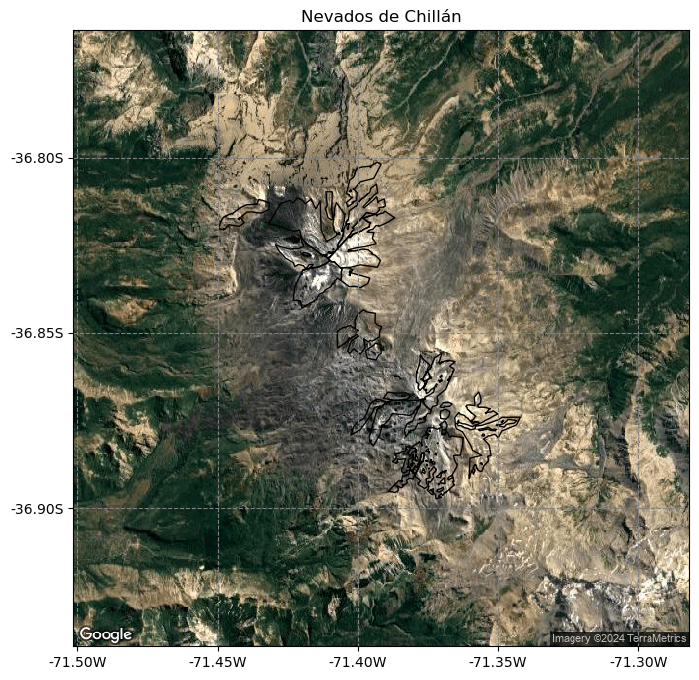

In [7]:
# map from google maps 
f, ax = plt.subplots(1,1,figsize=(8, 8))
graphics.plot_googlemap(gdirs, ax=ax)
ax.set_title('Nevados de Chillán');

  0% of 401.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of 401.9 MiB |######################| Elapsed Time: 0:00:14 Time:  0:00:14


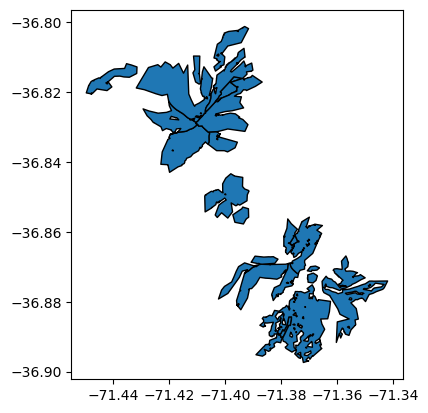

In [9]:
# if want to plot glaciers with no background map
al = utils.get_rgi_glacier_entities(rgi_ids, version='62')
al.plot(edgecolor='k');

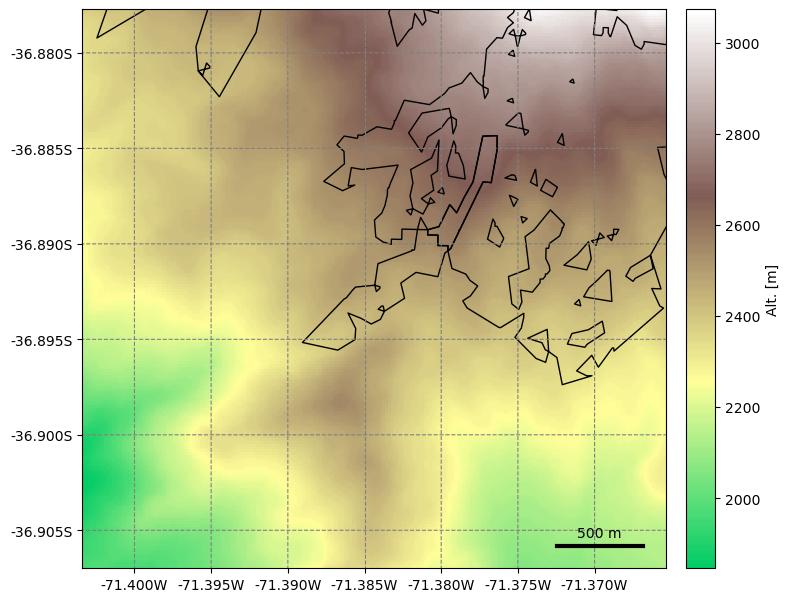

In [6]:
#alternative map option, can't figure out zoom though 
graphics.plot_domain(gdirs, figsize=(8, 8))

## Following "Working with the RGI files"
https://oggm.org/tutorials/stable/notebooks/beginner/working_with_rgi.html

In [13]:
# Use the RGI files to start an OGGM run
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=100,
                             y0=2009, halfsize=10, output_filesuffix='_2000')
ds2000 = utils.compile_run_output(gdirs, input_filesuffix='_2000')

2024-05-11 19:28:02: oggm.workflow: Execute entity tasks [run_random_climate] on 25 glaciers
2024-05-11 19:28:07: oggm.utils: Applying global task compile_run_output on 25 glaciers
2024-05-11 19:28:07: oggm.utils: Applying compile_run_output on 25 gdirs.


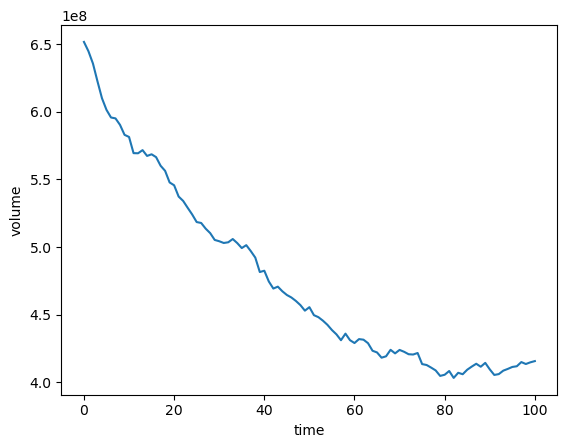

In [11]:
ds2000.sum(dim='rgi_id').volume.plot();

time = 0 is 2009, so I guess the total volume of ice in that year was 6.5 gt? 
but what's the random climate?

## Following the directions here:
 https://oggm.org/tutorials/stable/notebooks/advanced/massbalance_calibration.html#back-to-where-we-started-how-did-we-calibrate-the-default-pre-processed-directories-in-oggm-1-6

In [7]:
# Pick a glacier to look at climate info, #16 is Glaciar Nevado 
gdir_hef = gdirs[16]
gdir_hef.get_climate_info()

{'baseline_climate_source': 'GSWP3_W5E5',
 'baseline_yr_0': 1901,
 'baseline_yr_1': 2019,
 'baseline_climate_ref_hgt': 1675.0,
 'baseline_climate_ref_pix_lon': -71.25,
 'baseline_climate_ref_pix_lat': -36.75}

In [8]:
# Let’s have a look at the mass balance parameters for a glacier in the list
gdir_hef.read_json('mb_calib')
# mass balance from 2000-2020 is -783.5 [kg m-2]

#hmm.. mass balance error is larger than the total mass balance for many of the smaller glaciers,,, that's not good.... 

{'rgi_id': 'RGI60-17.13045',
 'bias': 0,
 'melt_f': 12.601531182265617,
 'prcp_fac': 1.4448853903798025,
 'temp_bias': -5.273351613897739,
 'reference_mb': -783.5,
 'reference_mb_err': 160.70000000000002,
 'reference_period': '2000-01-01_2020-01-01',
 'mb_global_params': {'temp_default_gradient': -0.0065,
  'temp_all_solid': 0.0,
  'temp_all_liq': 2.0,
  'temp_melt': -1.0},
 'baseline_climate_source': 'GSWP3_W5E5'}

In [17]:
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-ref-mb', reset=True)
cfg.PARAMS['border'] = 80
cfg.PARAMS['store_model_geometry'] = True

2024-05-11 19:32:42: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-11 19:32:42: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-11 19:32:42: oggm.cfg: Multiprocessing: using all available processors (N=2)
2024-05-11 19:32:42: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [25]:
# (The second glacier here we will only use in the second part of this notebook.)
# in OGGM v1.6 you have to explicitly indicate the url from where you want to start from
# we will use here the centerlines to actually look at different flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/'
            'L3-L5_files/2023.1/centerlines/W5E5/')
gdirs = workflow.init_glacier_directories(['RGI60-17.13009', 'RGI60-17.13011', 'RGI60-17.13013', 'RGI60-17.13014', 'RGI60-17.13018', 'RGI60-17.13020', 'RGI60-17.13021', 
           'RGI60-17.13022', 'RGI60-17.13024', 'RGI60-17.13026', 'RGI60-17.13029', 'RGI60-17.13030', 'RGI60-17.13031', 'RGI60-17.13033', 
           'RGI60-17.13034', 'RGI60-17.13044', 'RGI60-17.13045', 'RGI60-17.13047', 'RGI60-17.13049', 'RGI60-17.13050', 'RGI60-17.13051', 
           'RGI60-17.13052', 'RGI60-17.13054', 'RGI60-17.13056', 'RGI60-17.13058'], from_prepro_level=4,
                                          prepro_base_url=DEFAULT_BASE_URL)
# when using centerlines, the new default `SemiImplicit` scheme does not work at the moment,
# we have to use the `FluxBased` scheme instead:
cfg.PARAMS['evolution_model'] = 'FluxBased'

gdir = gdirs[16]
tasks.init_present_time_glacier(gdir)

2024-05-11 19:37:16: oggm.workflow: init_glacier_directories from prepro level 4 on 25 glaciers.
2024-05-11 19:37:16: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 25 glaciers
2024-05-11 19:37:16: oggm.workflow: WARNING: you are trying to run an entity task on 25 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


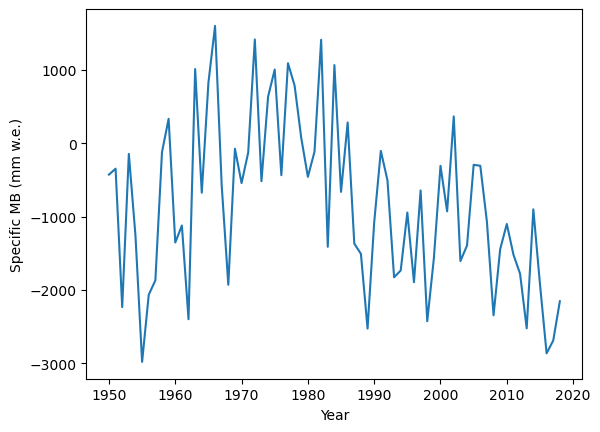

In [26]:
# computing mass balance from static directory 
# Get the calibrated mass-balance model - the default is to use OGGM's "MonthlyTIModel"
mbmod = massbalance.MultipleFlowlineMassBalance(gdir)
# i think this is just computing mass balance for glaciar nevado (# 16) 

# Compute the specific MB for this glacier
fls = gdir.read_pickle('model_flowlines')
years = np.arange(1950, 2019)
mb_ts = mbmod.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');

Mass-balance profiles on flowlines
Let’s start by noting that I used the MultipleFlowlineMassBalance model here. This is what OGGM uses for its runs, because we allow different model parameters for different flowlines. In many cases we don’t need this, but sometimes we do. Let’s see if we have different mass-balance model parameters for Hintereisferner or not. Note, that the new calibration can cause any of the mass-balance model parameters (melt factor, temperature bias or precipitation factor) to be different (more in the massbalance_calibration notebook).

In [27]:
for flmod in mbmod.flowline_mb_models:
    print(flmod.melt_f, f'{flmod.temp_bias:.2f}', f'{flmod.prcp_fac:.2f}')

12.601531182265617 -5.27 1.44


So here we have the same mass-balance model parameters for each flowline (that’s frequently the case). To get the mass-balance as a function of height we have several possibilities:

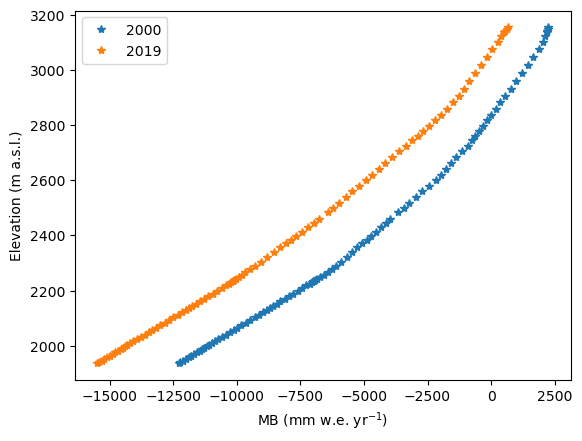

In [32]:
# Where the flowlines are:
heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=2000)
# units kg ice per second to mm w.e. per year:
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 

# Plot
plt.plot(mb, heights, '*', label='2000');

# Another year: (2019 is the latest you can do i guess)
heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=2019)
# units kg ice per second to mm w.e. per year:
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 

# Plot
plt.plot(mb, heights, '*', label='2019');
plt.ylabel('Elevation (m a.s.l.)'); plt.xlabel('MB (mm w.e. yr$^{-1}$)'); plt.legend();

maybeeee the summit ice cap has a positive mass balance in 2019 but barely. now surely all below the ELA

## Mass-balance during a transient run + bonus info (timestamps in OGGM)
### Specific (glacier-wide) mass-balance
At the time of writing, we only store the glacier volume, which is roughly equivalent to the mass-balance (up to numerical accuracy in the dynamical model).

In [33]:
# We want to use these flowline files for the AAR (see later)
cfg.PARAMS['store_fl_diagnostics'] = True
# Run from outline inventory year (2003 for HEF) to 2017 (end of CRU data in hydro year convention, see below)
tasks.run_from_climate_data(gdir, ye=2020);

2024-05-11 19:45:12: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.


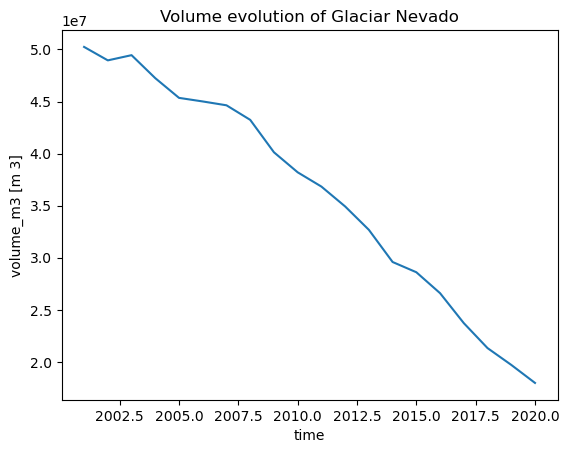

In [34]:
ds_diag = xr.open_dataset(gdir.get_filepath('model_diagnostics'))
ds_diag.volume_m3.plot(); plt.title('Volume evolution of Glaciar Nevado');

## Mass balance profiles 

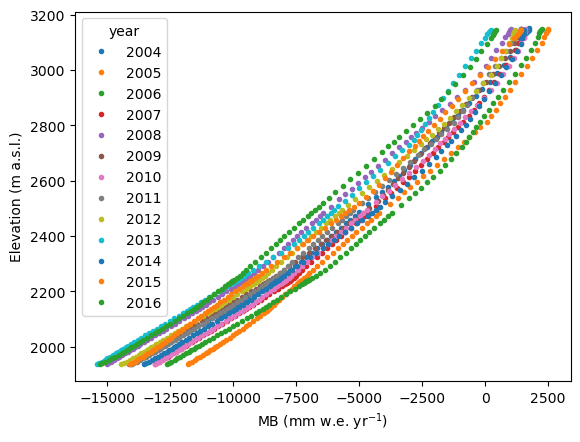

In [36]:
# This reads the model output file and makes it look like an OGGM flowline model
dyn_mod = flowline.FileModel(gdir.get_filepath('model_geometry'))
# Get the calibrated mass-balance model
mbmod = massbalance.MultipleFlowlineMassBalance(gdir)
# We can loop over the years and read the flowlines for each year
for year in range(2004, 2017):
    dyn_mod.run_until(year)
    # Compute the SMB from the mass balance model and the flowlines heights at each year
    h = []
    smb = []
    for fl_id, fl in enumerate(dyn_mod.fls):
        h = np.append(h, fl.surface_h)
        mb = mbmod.get_annual_mb(fl.surface_h, year=year, fl_id=fl_id) 
        smb = np.append(smb, mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] )
    plt.plot(smb, h, '.', label=year)

plt.legend(title='year');
plt.ylabel('Elevation (m a.s.l.)'); plt.xlabel('MB (mm w.e. yr$^{-1}$)');

## Compute and compile the ELA: 

In [37]:
global_tasks.compile_ela(gdirs, ys=2000, ye=2019);

2024-05-11 19:51:25: oggm.utils: Applying global task compile_ela on 25 glaciers
2024-05-11 19:51:25: oggm.workflow: Execute entity tasks [compute_ela] on 25 glaciers
2024-05-11 19:51:25: oggm.workflow: WARNING: you are trying to run an entity task on 25 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


Per default, the file will be stored in the working directory and named ELA.hdf (you can choose to save the data in a csv file instead by setting the csv keyword to True). The location where the file is saved can be changed by specifying the path keyword.

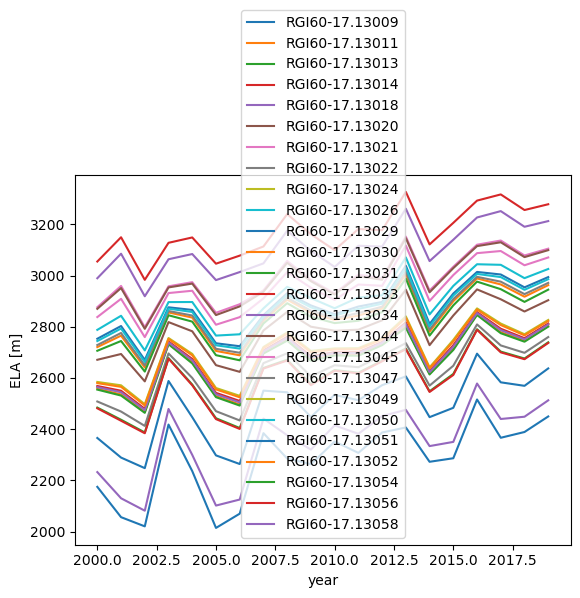

In [38]:
# Read the file
ela_df = pd.read_hdf(os.path.join(cfg.PATHS['working_dir'], 'ELA.hdf'))

# Plot it
ela_df.plot();
plt.xlabel('year'); plt.ylabel('ELA [m]');

When looking at many glaciers it might be useful to also plot the mean or average of the data. Let’s plot the mean ELA and the glacier area weighted ELA average. Of course, if you only use a few glaciers, as here, it can be much more robust to use the median instead.

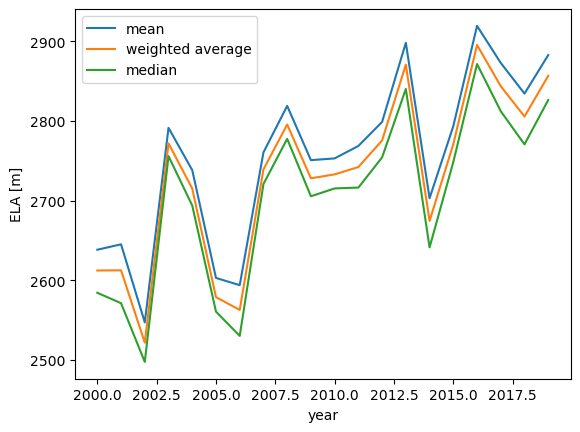

In [39]:
areas = [gd.rgi_area_km2 for gd in gdirs]

avg = ela_df.mean(axis=1).to_frame(name='mean')
avg['weighted average'] = np.average(ela_df, axis=1, weights=areas)
avg['median'] = np.median(ela_df, axis=1)

avg.plot();
plt.xlabel('year'); plt.ylabel('ELA [m]');

How would the ELA look like if the climate is 1° warmer? Lets have a look at one of the glaciers:

In [40]:
mbmod = massbalance.MonthlyTIModel(gdir, filename='climate_historical')
# gdir is still glaciar nevado

In [41]:
mbmod

<oggm.MassBalanceModel>
  Class: MonthlyTIModel
  Attributes:
    - hemisphere: sh
    - climate_source: GSWP3_W5E5
    - melt_f: 12.60
    - prcp_fac: 1.44
    - temp_bias: -5.27
    - bias: 0.00
    - rho: 900.0
    - t_solid: 0.0
    - t_liq: 2.0
    - t_melt: -1.0
    - repeat: False
    - ref_hgt: 1675.0
    - ys: 1901
    - ye: 2019

In [42]:
# We first need to get the currently applied temperature bias (that corrects for biases
# in the local climate) and then we add the additional temperature bias on top of it 
# (note that since OGGM v1.6, the calibrated temp_bias is very likely to be 
# different for every glacier)
corr_temp_bias = gdirs[0].read_json('mb_calib')['temp_bias']
corr_temp_bias

-5.273351613897739

In [43]:
global_tasks.compile_ela(gdirs[0], ys=2000, ye=2019,
                        temperature_bias=corr_temp_bias+1,
                        filesuffix='_t1')
ela_df_t1 = pd.read_hdf(os.path.join(cfg.PATHS['working_dir'], 'ELA_t1.hdf'))

2024-05-11 19:54:15: oggm.utils: Applying global task compile_ela on 1 glaciers
2024-05-11 19:54:15: oggm.workflow: Execute entity tasks [compute_ela] on 1 glaciers


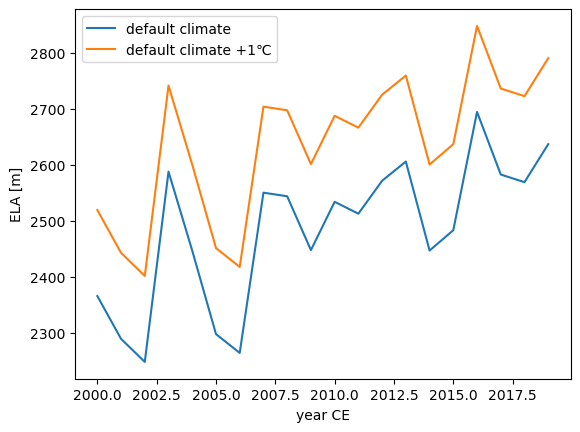

In [44]:
# we only look at the first glacier
plt.plot(ela_df[[ela_df.columns[0]]].mean(axis=1), label='default climate')
plt.plot(ela_df_t1.mean(axis=1), label=('default climate +1℃'))
plt.xlabel('year CE'); plt.ylabel('ELA [m]'); plt.legend();

By using the precipitation_factor keyword, you can change the precipitation. Feel free to try that by yourself! At the moment, gdirs[0].read_json('mb_calib')['prcp_fac'] is applied.

## Lizz and Rodrigo mentioned the importance of precipitation factor here!!

"If your goal is to estimate the glacier contribution relative to the streamflow time series (which are quite far from the glaciers), your percentage contribution will be proportional to the precipitation factor (e.g. https://doi.org/10.1017/aog.2023.57), so I would try to leave it at 1 and try to use the best possible precipitation source (which brings us to your first point)." 

"Yes, agreed with Rodrigo, and I want to add a little more context.  The precipitation factor is necessary because global datasets underestimate sources like orographic precipitation, avalanching, etc., so we *must* scale up precipitation from global models.  That is why a precip factor of 1 on W5E5 will likely underestimate precipitation measured locally.  If you are using a local dataset to force (which is what Rodrigo did eventually, with the Patagonia regional dataset, right?) then a precip factor of 1 to match the source may be appropriate…as long as you believe the forcing dataset is capturing the precipitation at the altitude of the glacier."

In [55]:
# manually changing the precipitation factor here to 1, since it was 1.4 automatically 
mbmod = massbalance.MonthlyTIModel(gdir, filename='climate_historical', prcp_fac = 1) 

In [54]:
mbmod

<oggm.MassBalanceModel>
  Class: MonthlyTIModel
  Attributes:
    - hemisphere: sh
    - climate_source: GSWP3_W5E5
    - melt_f: 12.60
    - prcp_fac: 1.00
    - temp_bias: -5.27
    - bias: 0.00
    - rho: 900.0
    - t_solid: 0.0
    - t_liq: 2.0
    - t_melt: -1.0
    - repeat: False
    - ref_hgt: 1675.0
    - ys: 1901
    - ye: 2019

In [56]:
# compare ELA with new precipitation factor: 
global_tasks.compile_ela(gdirs[0], ys=2000, ye=2019,
                        filesuffix='_t1')
ela_df_t1 = pd.read_hdf(os.path.join(cfg.PATHS['working_dir'], 'ELA_t1.hdf'))

2024-05-11 20:11:22: oggm.utils: Applying global task compile_ela on 1 glaciers
2024-05-11 20:11:22: oggm.workflow: Execute entity tasks [compute_ela] on 1 glaciers


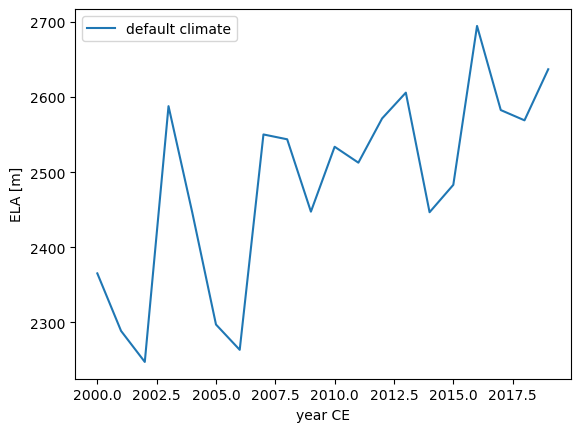

In [59]:
# huh it looks the same as before i changed the precip factor? might be doing something wrong here
plt.plot(ela_df[[ela_df.columns[0]]].mean(axis=1), label='default climate')
plt.xlabel('year CE'); plt.ylabel('ELA [m]'); plt.legend();

## returning to the tutorial now:

In [45]:
# Looking at a longer timeseries: 
global_tasks.compile_ela(gdir, ys=1902, ye=2019, filesuffix='_1901_2019', csv=True)
ela_df_long = pd.read_csv(os.path.join(cfg.PATHS['working_dir'], 'ELA_1901_2019.csv'),
                          index_col=0)

2024-05-11 19:55:43: oggm.utils: Applying global task compile_ela on 1 glaciers
2024-05-11 19:55:43: oggm.workflow: Execute entity tasks [compute_ela] on 1 glaciers


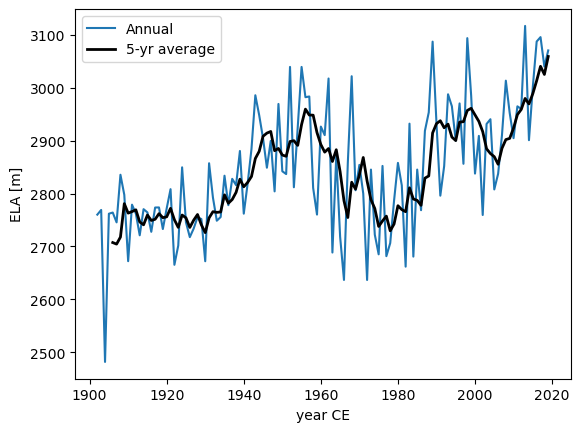

In [46]:
# The ELA can have a high year-to-year variability. Therefore we plot in addition to the regular ELA timeseries, the 5-year moving average.

ax = ela_df_long.plot();
ela_df_long.rolling(5).mean().plot(ax=ax, lw=2, color='k', label='')
plt.xlabel('year CE'); plt.ylabel('ELA [m]'); ax.legend(["Annual", "5-yr average"]);

In case you’re only intrested in specific years there is an option to just compute the ELA in those years. There is actually no need to save this data. Therefore we now just compute the ELA.

In [47]:
yrs = [2000, 1950, 1980, 1960]
ela_yrs = massbalance.compute_ela(gdir, years=yrs)
ela_yrs

2000    2837.690107
1950    2842.078317
1980    2857.886760
1960    2926.544807
dtype: float64

^ this looks whack why is 1960 the highest ela?

## Accumulation Area Ratio

Like the ELA, the Accumulation Area Ratio (AAR) is a diagostic variable. The AAR is currently not an output variable in OGGM, but it can easily be computed. It is even a part of the glacier simulator and its documentation. Below we give an example of how it can be computed after a model run. From the ELA computation, we already know the height where the mass balance is equal to zero. Now we need to compute the area of the glacier that is located above that line. Let’s start with a static geometry glacier with multiple flowlines.

We first search the points along the flowlines that are above the ELA in a given year. Lets use Hintereisferner.

We use a True, False array saying which part is above the ELA and sum the corresponding area at each timestep:

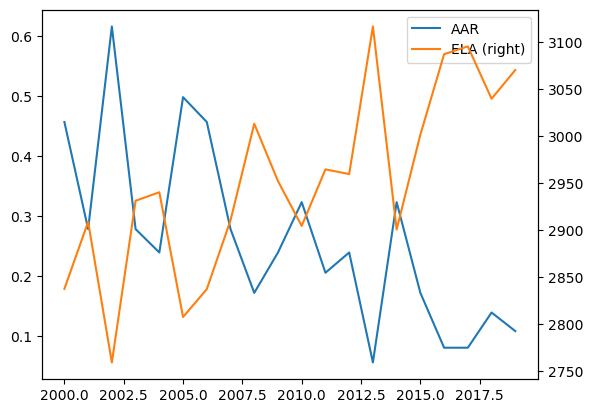

In [48]:
rgi_id = 'RGI60-17.13045'

tot_area = 0
tot_area_above = 0
for fl in fls:
    # The area is constant
    tot_area += fl.area_m2
    # The area above a certain limit is not - we make a (nx, nt) array
    # This is a little bit of dimensional juggling (broadcasting)
    is_above = (fl.surface_h[:, np.newaxis, ] > ela_df[rgi_id].values)
    # Here too - but the time dim is constant
    area = fl.bin_area_m2[:, np.newaxis] * np.ones(len(ela_df))
    tot_area_above += (area * is_above).sum(axis=0)

# Write the output
fixed_aar = pd.DataFrame(index=ela_df.index)
fixed_aar['AAR'] = tot_area_above / tot_area

# Plot ELA and AAR on the same plot
fixed_aar['ELA'] = ela_df[rgi_id]
fixed_aar.plot(secondary_y='ELA');

Unsurprisingly, the AAR is strongly correlated to the ELA, but it is not fully linear due to the area distribution of the glacier:

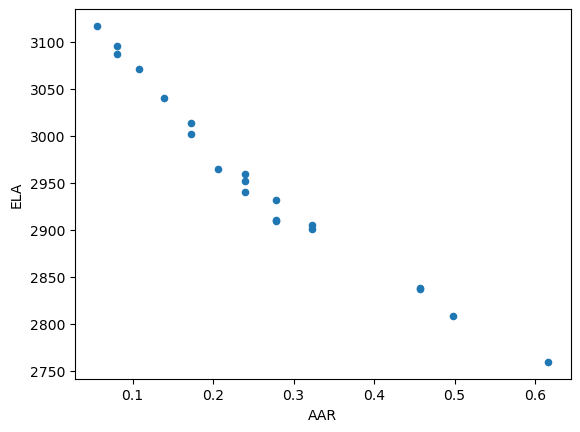

In [49]:
fixed_aar.plot.scatter(x='AAR', y='ELA');

Now that we have looked at the static case, let’s to the same for glaciers with changing surface height:

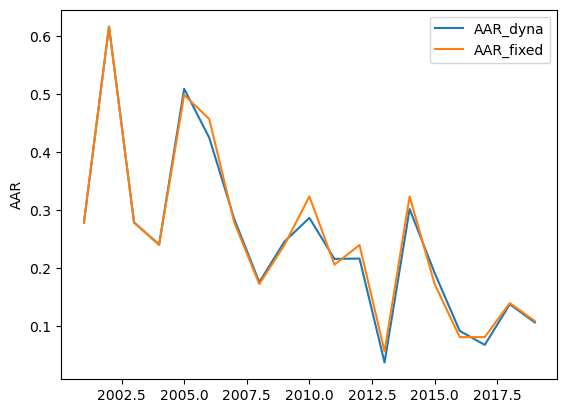

In [50]:
# We start by reading the flowline geometry diagnostic files
tot_area = 0
tot_area_above = 0

ela_ds = xr.DataArray(ela_df[rgi_id], dims=('time'))

for fn in np.arange(len(fls)):
    with xr.open_dataset(gdir.get_filepath('fl_diagnostics'), group='fl_' + str(fn)) as ds:
        ds = ds.load()
    tot_area += ds.area_m2.sum(dim='dis_along_flowline')

    # Compute the surface elevation
    surface_h = ds.thickness_m + ds.bed_h

    # In xarray things are much easier - the broadcasting is automatic
    is_above = surface_h > ela_ds
    area = is_above * ds.area_m2
    tot_area_above += (area * is_above).sum(dim='dis_along_flowline')

# Write the output
dyna_aar = pd.DataFrame(index=tot_area_above.time)
dyna_aar['AAR_dyna'] = tot_area_above / tot_area
dyna_aar['AAR_fixed'] = fixed_aar['AAR']

dyna_aar.plot(); plt.ylabel('AAR');

You can see in the plot that the difference between the AAR calculated from the dynamic glacier and the one of the static glacier is quite similar. Over time you can expect that this difference becomes larger. Feel free to play around with that.

Keep in mind that this is just an example for computing the AAR. For a different glacier experiment you might need to adjust the code. e.g. if the glacier flowlines would have different MB model parameters, you need to take that in to consideration.

Here we computed the AAR from the “model perspective”, where the glacier is located in bins. You can however also choose to do some interpolation between the grid point above and below the ELA.

## cant remember which workbook this was: 

In [9]:
# mass balance estimation for each glacier! over 20 year period 
for gdir in gdirs:
    mbmod = massbalance.MonthlyTIModel(gdir)
    mean_mb = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'),
                                               year=np.arange(2000,2020,1)).mean()
    print(gdir.rgi_id, f': average MB 2000-2020 = {mean_mb:.1f} kg m-2, ',
          f"prcp_fac: {gdir.read_json('mb_calib')['prcp_fac']:.2f}")
    
# Biggest MB change is for RGI 17.13044, 13045, and 13050

RGI60-17.13009 : average MB 2000-2020 = -73.7 kg m-2,  prcp_fac: 1.88
RGI60-17.13011 : average MB 2000-2020 = -126.1 kg m-2,  prcp_fac: 1.44
RGI60-17.13013 : average MB 2000-2020 = -199.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13014 : average MB 2000-2020 = -449.9 kg m-2,  prcp_fac: 1.44
RGI60-17.13018 : average MB 2000-2020 = -106.5 kg m-2,  prcp_fac: 1.44
RGI60-17.13020 : average MB 2000-2020 = -460.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13021 : average MB 2000-2020 = -573.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13022 : average MB 2000-2020 = -366.9 kg m-2,  prcp_fac: 1.44
RGI60-17.13024 : average MB 2000-2020 = -98.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13026 : average MB 2000-2020 = -428.9 kg m-2,  prcp_fac: 1.44
RGI60-17.13029 : average MB 2000-2020 = -92.8 kg m-2,  prcp_fac: 1.44
RGI60-17.13030 : average MB 2000-2020 = -124.5 kg m-2,  prcp_fac: 1.44
RGI60-17.13031 : average MB 2000-2020 = -127.1 kg m-2,  prcp_fac: 1.44
RGI60-17.13033 : average MB 2000-2020 = -460.8 kg m-2,  prcp_fac: 1.44
RGI60-17.

## First, let’s check if the OGGM calibration worked at all

we will get first the average modelled MB:

In [33]:
h, w = gdir_hef.get_inversion_flowline_hw()
mb_geod = massbalance.MonthlyTIModel(gdir_hef)
# Note, if you change cfg.PARAMS['geodetic_mb_period'], you need to change the years here as well!
mbdf= pd.DataFrame(index = np.arange(1970,2020,1)) ## was originally from 2000 not 1970 
mbdf['mod_mb'] = mb_geod.get_specific_mb(h, w, year=mbdf.index)
mbdf.mean()

mod_mb   -221.18281
dtype: float64

then get the observed geodetic MB that we calibrated our mass-balance to:

In [11]:
print('reference MB: ' + str(gdir_hef.read_json('mb_calib')['reference_mb'])+ ' kg m-2')
print('reference MB uncertainties: '+ str(gdir_hef.read_json('mb_calib')['reference_mb_err'])+ ' kg m-2')
print('reference MB time period: ' + gdir_hef.read_json('mb_calib')['reference_period'])

reference MB: -783.5 kg m-2
reference MB uncertainties: 160.70000000000002 kg m-2
reference MB time period: 2000-01-01_2020-01-01


In [12]:
# #this tests if the two parameters are very similar: (they're not!!) not sure what to do with this info... 
# np.testing.assert_allclose(gdir_hef.read_json('mb_calib')['reference_mb'], mbdf['mod_mb'].mean())

# #AssertionError: 
# #Not equal to tolerance rtol=1e-07, atol=0
# #...
# #Mismatched elements: 1 / 1 (100%)

## interesting... modelled and observed MB look very different... not good lol

In [13]:
# if you use the default calibration data from Hugonnet et al., 2021, 
# we can get the geodetic data from any glacier from here:
ref_mb_df = utils.get_geodetic_mb_dataframe().loc[gdir_hef.rgi_id]
ref_mb_df = ref_mb_df.loc[ref_mb_df['period'] == cfg.PARAMS['geodetic_mb_period']].iloc[0]
# dmdtda: in meters water-equivalent per year -> we convert to kg m-2 yr-1
ref_mb = ref_mb_df['dmdtda'] * 1000
ref_mb

-783.5

In [14]:
# Let's calibrate the melt_f (this is the default option in mb_calibration_from_scalar_mb)
# overwrite_gdir has to be set to True,
# because we want to overwrite the old calibration
mb_calibration_from_scalar_mb(gdir_hef,
                              ref_mb = ref_mb, 
                              ref_period=cfg.PARAMS['geodetic_mb_period'],
                              overwrite_gdir=True);

mb_melt_f = massbalance.MonthlyTIModel(gdir_hef)
mbdf['mod_mb_melt_f'] = mb_melt_f.get_specific_mb(h, w, year=mbdf.index)

In [15]:
gdir_hef.read_json('mb_calib')

{'rgi_id': 'RGI60-17.13045',
 'bias': 0,
 'melt_f': 2.861072183400736,
 'prcp_fac': 1.806106737974753,
 'temp_bias': 0,
 'reference_mb': -783.5,
 'reference_mb_err': None,
 'reference_period': '2000-01-01_2020-01-01',
 'mb_global_params': {'temp_default_gradient': -0.0065,
  'temp_all_solid': 0.0,
  'temp_all_liq': 2.0,
  'temp_melt': -1.0},
 'baseline_climate_source': 'GSWP3_W5E5'}

We will now instead fix the melt_f and the prcp_fac, and use the temp_bias as free variable for calibration. For that we overwrite the default value of calibrate_param1:

In [16]:
# Let's calibrate on the temp_bias instead
# overwrite_gdir has to be set to True,
# because we want to overwrite the old calibration
mb_calibration_from_scalar_mb(gdir_hef,
                              ref_mb = ref_mb, 
                              ref_period=cfg.PARAMS['geodetic_mb_period'],
                              calibrate_param1='temp_bias',
                              overwrite_gdir=True)

mb_temp_b = massbalance.MonthlyTIModel(gdir_hef)
mbdf['mod_mb_temp_b'] = mb_temp_b.get_specific_mb(h, w, year=mbdf.index)

In [17]:
mb_params = gdir_hef.read_json('mb_calib')
mb_params['temp_bias'], mb_params['prcp_fac'], mb_params['melt_f']

(-2.40442185773151, 1.806106737974753, 5.0)

Here we used the median melt_f and the same prcp_fac as in the previous option, but changed temp_bias until the ref_mb is matched. As the melt_f is higher than in the previous calibration option, we need to have a negative temp_bias to get to the same average MB (i.e., ref_mb).

Similarly, we can also just calibrate on the precipitation factor (prcp_fac).

In [18]:
# Let's calibrate on the prcp_fac instead
# overwrite_gdir has to be set to True,
# because we want to overwrite the old calibration
mb_calibration_from_scalar_mb(gdir_hef,
                              ref_mb = ref_mb, 
                              ref_period=cfg.PARAMS['geodetic_mb_period'],
                              calibrate_param1='prcp_fac',
                              overwrite_gdir=True)

mb_prcp_fac = massbalance.MonthlyTIModel(gdir_hef)
mbdf['mod_mb_prcp_fac'] = mb_prcp_fac.get_specific_mb(h, w, year=mbdf.index)

mb_params = gdir_hef.read_json('mb_calib')
mb_params['temp_bias'], mb_params['prcp_fac'], mb_params['melt_f']

(0, 3.562965301830301, 5.0)

Calibrate prcp_fac, fixed temp_bias and melt_f

Let’s plot how well we match the interannual observations for the different calibration options:

Text(0.5, 1.0, 'Comparing mass-balance estimates for Glaciar Nevado')

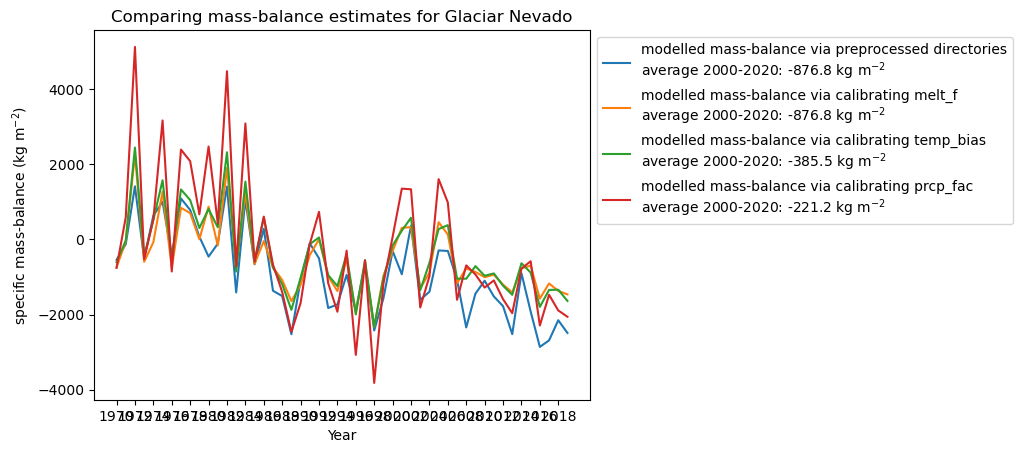

In [19]:
plt.plot(mbdf['mod_mb'],
         label='modelled mass-balance via preprocessed directories\n'+f'average 2000-2020: {mbdf.mod_mb.mean():.1f} ' + r'kg m$^{-2}$')
plt.plot(mbdf['mod_mb_melt_f'],
         label='modelled mass-balance via calibrating melt_f\n'+f'average 2000-2020: {mbdf.mod_mb.mean():.1f} ' + r'kg m$^{-2}$')
plt.plot(mbdf['mod_mb_temp_b'],
         label='modelled mass-balance via calibrating temp_bias\n'+f'average 2000-2020: {mbdf.mod_mb_temp_b.mean():.1f} ' + r'kg m$^{-2}$')
plt.plot(mbdf['mod_mb_prcp_fac'],
         label='modelled mass-balance via calibrating prcp_fac\n'+f'average 2000-2020: {mbdf.mod_mb_prcp_fac.mean():.1f} ' + r'kg m$^{-2}$')
plt.xticks(np.arange(1970,2020,2)) ## was from 2000, not 1970 
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel(r'specific mass-balance (kg m$^{-2}$)')
plt.xlabel('Year');
plt.title('Comparing mass-balance estimates for Glaciar Nevado')

In [20]:
# look at DataFrame that contains all the annual mass balance estimates 
# hmm 1) can I make this monthly instead of annually? 
mbdf

,mod_mb,mod_mb_melt_f,mod_mb_temp_b,mod_mb_prcp_fac
1970,-541.575297,-745.437601,-605.506063,-753.868286
1971,-124.651235,-49.678835,-27.788972,592.265030
1972,1416.834278,2268.428038,2450.581424,5132.846109
1973,-516.140483,-595.644829,-458.289179,-524.268763
1974,637.748548,-71.652101,520.352993,538.876342
1975,1006.927381,1274.999079,1579.363277,3171.877257
1976,-434.022738,-754.903881,-519.145901,-853.013661
1977,1093.348548,844.618750,1333.943743,2396.195966
1978,786.735708,703.902755,1050.809109,2087.417464
1979,74.283120,6.063134,306.321273,670.520369


In [21]:
# To export csv of mass balance estimates: 
mbdf.to_csv('mbdf_data.csv', index=False)

## Playing with warming scenarios: 

In [23]:
# Do a random run with a bit of warming
tasks.run_random_climate(gdir, 
                         ys=2020, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
                         y0=2009, halfsize=10,  # Randome climate of 1999-2019
                         seed=1,  # Random number generator seed 
                         temperature_bias=1.5,  # additional warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         init_model_filesuffix='_spinup_historical',  # start from the spinup run
                         output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                        );

In [24]:
# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)

In [26]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

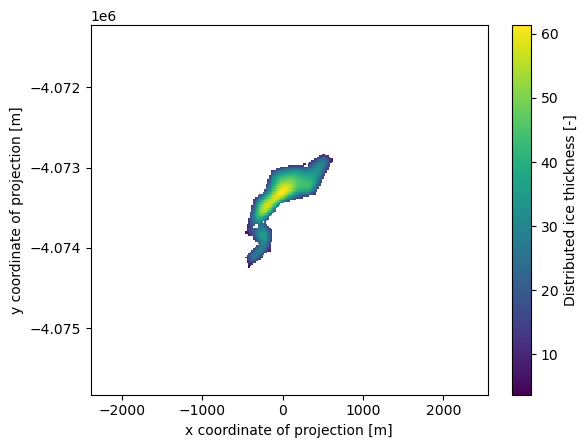

In [27]:
# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax);
ax.axis('equal');

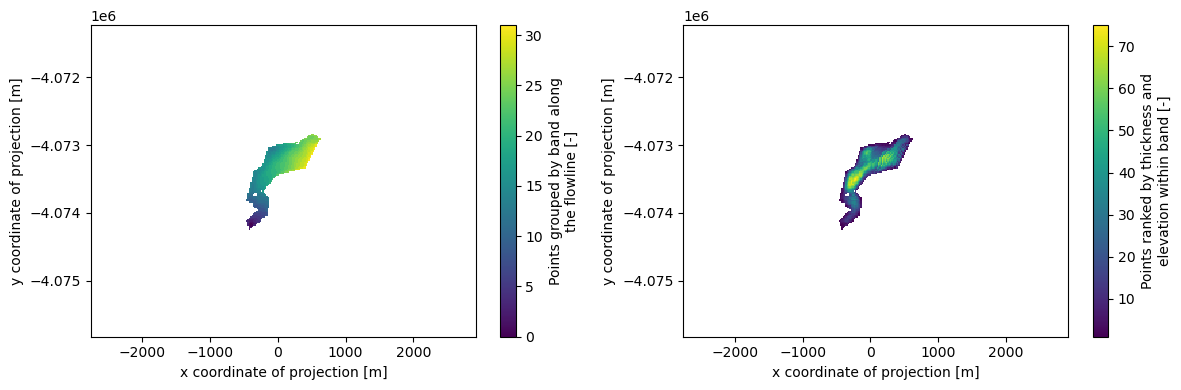

In [28]:
# Which points belongs to which band, and then within one band which are the first to melt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ds.band_index.plot(ax=ax1);
ds.rank_per_band.plot(ax=ax2);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();